In [1]:
import tensorflow as tf
print('TensorFlow:{}'.format(tf.__version__))
import numpy as np
print('NumPy:{}'.format(np.__version__))

import sklearn as sk
print('Scikit Learn:{}'.format(sk.__version__))
from sklearn import datasets as skds
from sklearn import model_selection as skms
from sklearn import preprocessing as skpp
import matplotlib.pyplot as plt


boston = skds.load_boston()
print(boston.DESCR)

X = boston.data.astype(np.float32)
y = boston.target.astype(np.float32)
if y.ndim == 1:
    y = y.reshape(len(y), 1)
# 将X中的特征缩放为均值为零和标准方差为1的特征
X = skpp.StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = skms.train_test_split(X, y, test_size=.4, random_state=123)

num_outputs = y_train.shape[1]
num_inputs = X_train.shape[1]

x_tensor = tf.placeholder(dtype=tf.float32,
                         shape=[None, num_inputs], 
                         name='x')
y_tensor = tf.placeholder(dtype=tf.float32,
                         shape=[None, num_outputs],
                         name='y')
w = tf.Variable(tf.zeros([num_inputs, num_outputs]),
               dtype=tf.float32,
               name='w')
b = tf.Variable(tf.zeros([num_outputs]),
               dtype=tf.float32,
               name='b')

model = tf.matmul(x_tensor, w) + b

# 定义Lasso回归参数
lasso_param = tf.Variable(0.8, dtype=tf.float32)
lasso_loss = tf.reduce_mean(tf.abs(w) * lasso_param)

# 
loss = tf.reduce_mean(tf.square(model - y_tensor)) + lasso_loss

# mse and R2
mse = tf.reduce_mean(tf.square(model - y_tensor))
y_mean = tf.reduce_mean(y_tensor)
total_error = tf.reduce_sum(tf.square(y_tensor - y_mean))
unexplained_error = tf.reduce_sum(tf.square(y_tensor - model))
rs = 1 - tf.div(unexplained_error, total_error)

learning_rete = 0.001
optimizer = tf.train.GradientDescentOptimizer(learning_rete).minimize(loss)

num_epochs = 1500
loss_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
mse_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
rs_epochs = np.empty(shape=[num_epochs], dtype=np.float32)

mse_score = 0
rs_score = 0

with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())
    for epoch in range(num_epochs):
        feed_dict = {x_tensor: X_train, y_tensor: y_train}
        loss_val, _ = tfs.run([loss, optimizer], feed_dict)
        loss_epochs[epoch] = loss_val
        
        feed_dict = {x_tensor: X_test, y_tensor: y_test}
        mse_score, rs_score = tfs.run([mse, rs], feed_dict)
        mse_epochs[epoch] = mse_score
        rs_epochs[epoch] = rs_score
        
print("For test data: MSE = {0:0.8f}, R2 = {1:0.8f}".format(mse_score, rs_score))




TensorFlow:1.13.1
NumPy:1.16.3
Scikit Learn:0.21.2
.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value 

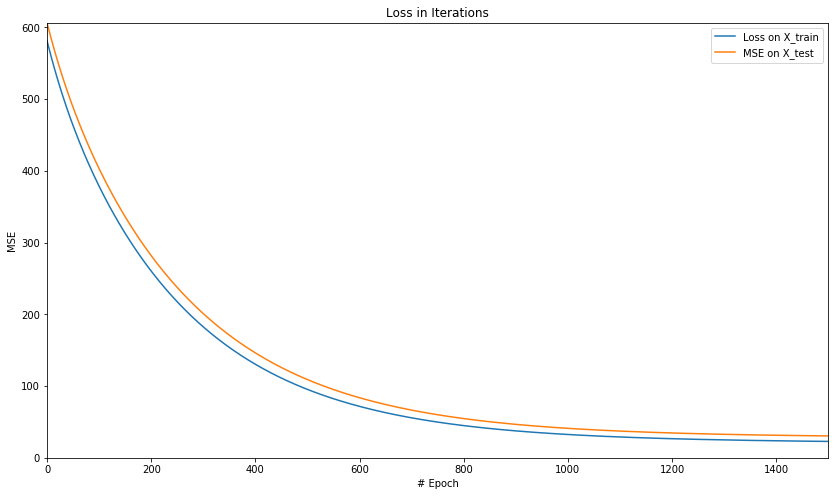

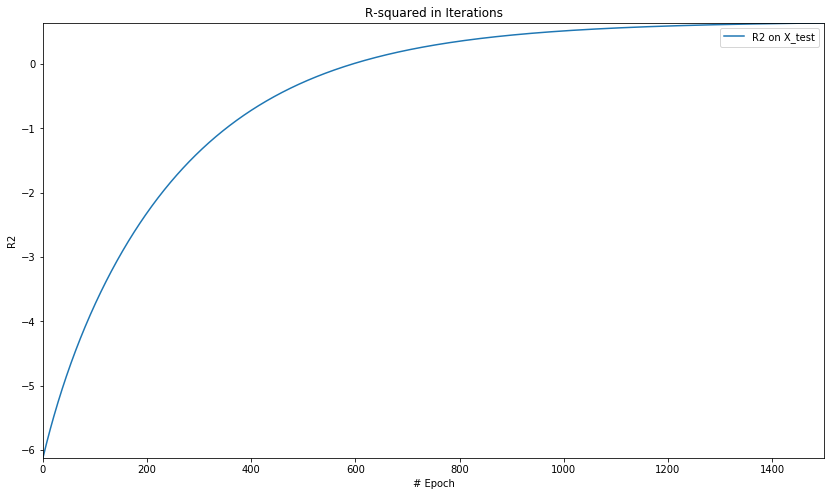

In [2]:
plt.figure(figsize=(14, 8))

plt.axis([0, num_epochs, 0, np.max(loss_epochs)])
plt.plot(loss_epochs, label='Loss on X_train')
plt.title('Loss in Iterations')
plt.xlabel('# Epoch')
plt.ylabel('MSE')

plt.axis([0, num_epochs, 0, np.max(mse_epochs)])
plt.plot(mse_epochs, label='MSE on X_test')
plt.xlabel('# Epoch')
plt.ylabel('MSE')
plt.legend()

plt.show()

plt.figure(figsize=(14, 8))

plt.axis([0, num_epochs, np.min(rs_epochs), np.max(rs_epochs)])
plt.title('R-squared in Iterations')
plt.plot(rs_epochs, label='R2 on X_test')
plt.xlabel('# Epoch')
plt.ylabel('R2')
plt.legend()

plt.show()